# Step 1: Defining Constants and Setting Up Environment


In [ ]:
# Define constants
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 102
DATASET_URL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
LABELS_URL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
EXTRACT_PATH = '/content/flowers_dataset'

# Step 2: Downloading and Extracting the Dataset


In [ ]:
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tarfile
import scipy.io
import urllib.request


# Function to download files
def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        print(f"Downloading {url.split('/')[-1]}...")
        urllib.request.urlretrieve(url, dest_path)
    else:
        print(f"{url.split('/')[-1]} already exists.")

# Download and extract dataset
def download_and_extract_dataset():
    dataset_archive = os.path.join(EXTRACT_PATH, '102flowers.tgz')
    labels_file = os.path.join(EXTRACT_PATH, 'imagelabels.mat')

    os.makedirs(EXTRACT_PATH, exist_ok=True)
    download_file(DATASET_URL, dataset_archive)
    download_file(LABELS_URL, labels_file)

    if not os.path.exists(os.path.join(EXTRACT_PATH, 'jpg')):
        print(f"Extracting {dataset_archive}...")
        with tarfile.open(dataset_archive, 'r:gz') as tar:
            tar.extractall(EXTRACT_PATH)
    else:
        print("Dataset already extracted.")



imagelabels.mat already exists.
Extracting /content/flowers_dataset/102flowers.tgz...
Dataset and labels successfully loaded!
Images Directory: /content/flowers_dataset/jpg
Labels File: /content/flowers_dataset/imagelabels.mat


# Step 3: Validating the Dataset


In [ ]:
# Validate dataset loading
def validate_dataset():
    dataset_path = os.path.join(EXTRACT_PATH, 'jpg')
    labels_path = os.path.join(EXTRACT_PATH, 'imagelabels.mat')

    if os.path.exists(dataset_path) and os.path.exists(labels_path):
        print("Dataset and labels successfully loaded!")
        print(f"Images Directory: {dataset_path}")
        print(f"Labels File: {labels_path}")
    else:
        raise FileNotFoundError("Error loading dataset or labels. Check paths and files.")

# Main setup
try:
    download_and_extract_dataset()
    validate_dataset()
except Exception as e:
    print(f"An error occurred: {e}")


# Step 4: Exploratory Data Analysis (EDA) on the 102 Flowers Dataset

##  Step 4.1: Loading and Inspecting the Labels
- The labels are stored in the imagelabels.mat file. Let’s load and explore them.

In [ ]:
import scipy.io
import numpy as np

# Load the labels
labels_path = os.path.join(EXTRACT_PATH, 'imagelabels.mat')
mat = scipy.io.loadmat(labels_path)
labels = mat['labels'][0]  # Extract the labels array

# Print basic information about the labels
print(f"Total images: {len(labels)}")
print(f"Unique classes: {len(np.unique(labels))}")
print(f"Labels: {np.unique(labels)}")


Total images: 8189
Unique classes: 102
Labels: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]


# Step 4.2: Label Distribution


<ipython-input-12-6c70b3d8ec3c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='viridis')


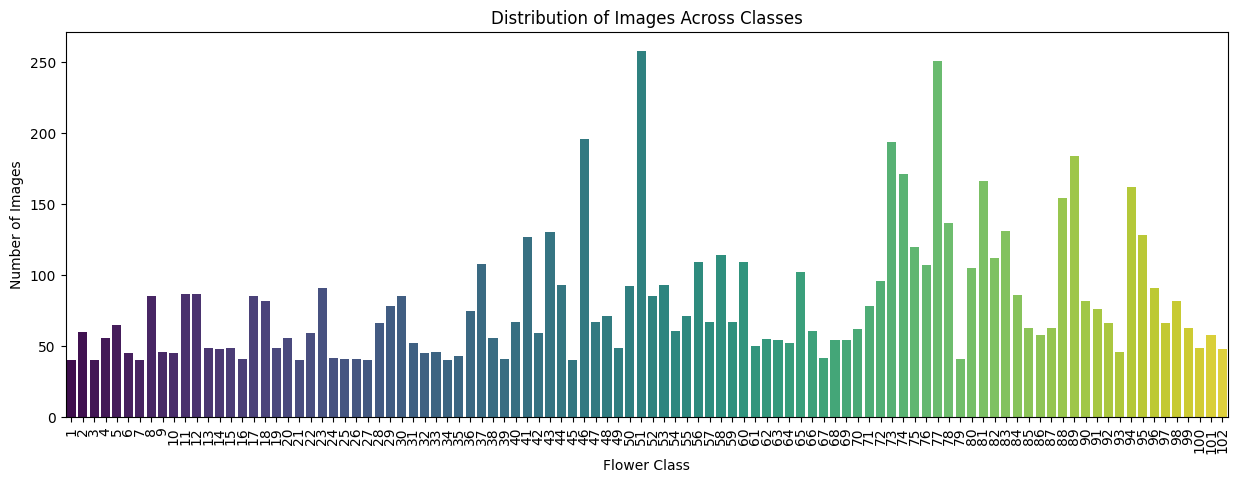

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of labels
plt.figure(figsize=(15, 5))
sns.countplot(x=labels, palette='viridis')
plt.title('Distribution of Images Across Classes')
plt.xlabel('Flower Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()


## Step 4.3: Visualizing Sample Images

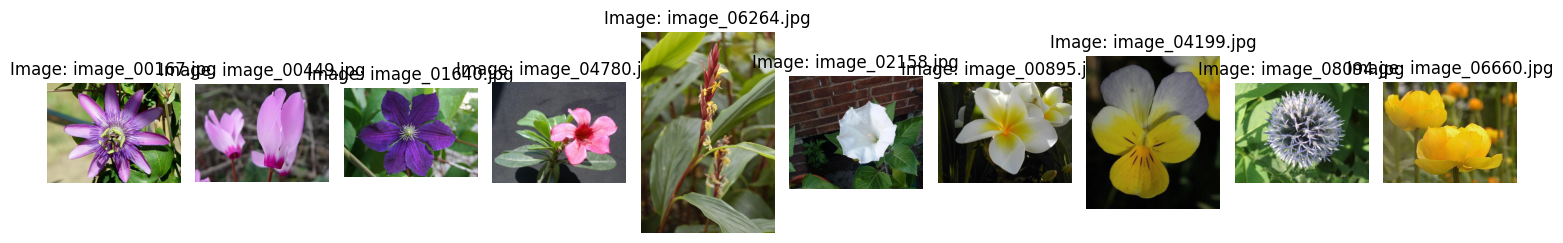

In [ ]:
import matplotlib.image as mpimg
import random
import matplotlib.pyplot as plt
# Path to the images directory
images_path = os.path.join(EXTRACT_PATH, 'jpg')
image_files = sorted(os.listdir(images_path))

# Display a few random images
num_samples = 10
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    img_file = random.choice(image_files)
    img_path = os.path.join(images_path, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {img_file}")

plt.tight_layout()
plt.show()


# Step 5: Further EDA and Dataset Preprocessing

# Step 5.1: Image Size Analysis

- Let’s analyze the dimensions of the images in the dataset. This helps determine if resizing is necessary and ensures all images have consistent dimensions.

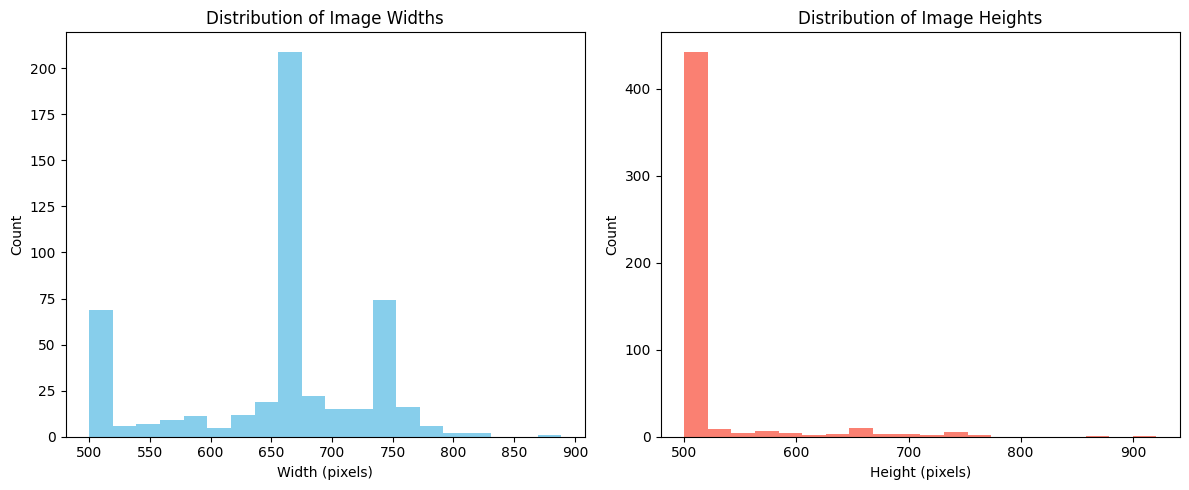

In [ ]:
from PIL import Image

# Analyze the dimensions of the images
image_sizes = []

for img_file in image_files[:500]:  # Limit to first 500 images for speed
    img_path = os.path.join(images_path, img_file)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

# Convert to numpy array for analysis
image_sizes = np.array(image_sizes)
widths, heights = image_sizes[:, 0], image_sizes[:, 1]

# Plot the distributions of widths and heights
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='skyblue')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='salmon')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Step 5.2: Resize and Normalize the images

- :For consistent model training, we resize all images to the same dimensions (e.g., 128x128) and normalize pixel values to [0, 1].

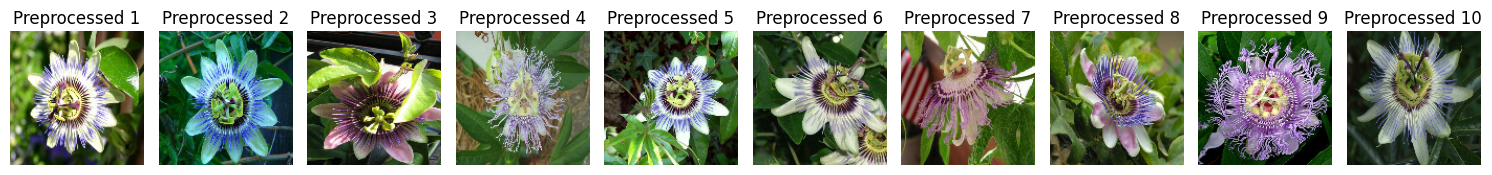

In [ ]:
import tensorflow as tf

IMG_SIZE = 128  # Target size for all images

# Function to preprocess a single image
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)  # Read the image file
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG format
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize image
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Preprocess a batch of images for visualization
sample_paths = [os.path.join(images_path, img) for img in image_files[:10]]
sample_images = [preprocess_image(path).numpy() for path in sample_paths]

# Visualize preprocessed images
plt.figure(figsize=(15, 5))
for i, img in enumerate(sample_images):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Preprocessed {i+1}")

plt.tight_layout()
plt.show()


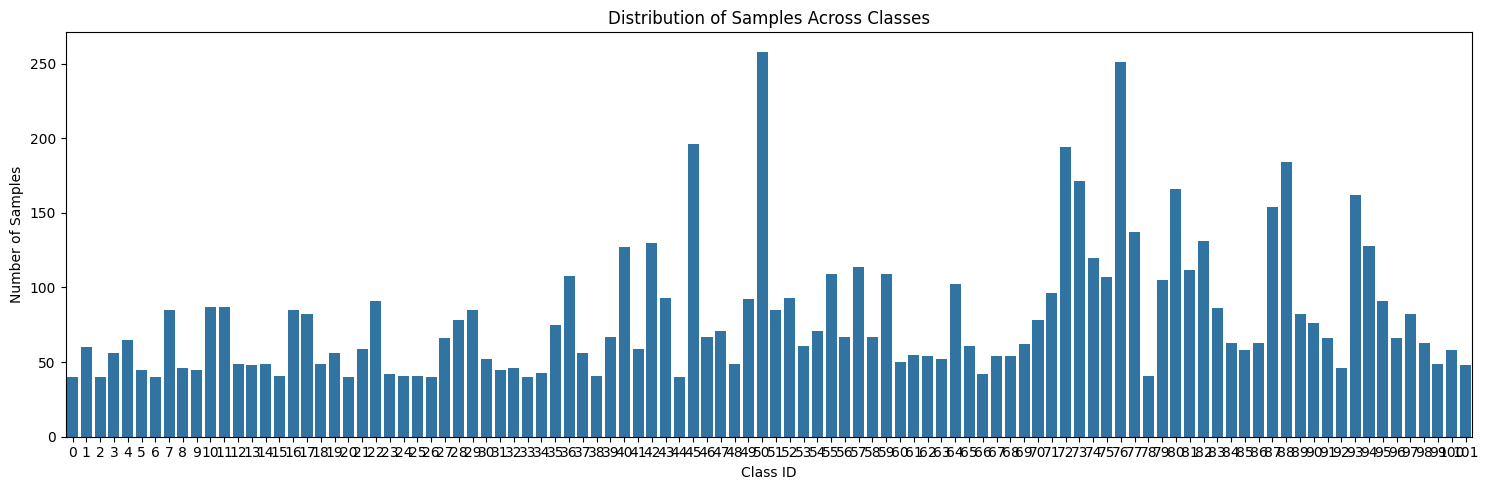

Minimum samples in a class: 40
Maximum samples in a class: 258
Average samples per class: 80.28


In [ ]:
# Step 1: Analyze Class Distribution
# This helps us understand if our dataset is balanced
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert labels to 0-based indexing (since they start from 1)
labels_zero_based = labels - 1

# Count samples in each class
class_counts = np.bincount(labels_zero_based)

# Visualize class distribution
plt.figure(figsize=(15, 5))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.title('Distribution of Samples Across Classes')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

# Print statistics
print(f"Minimum samples in a class: {np.min(class_counts)}")
print(f"Maximum samples in a class: {np.max(class_counts)}")
print(f"Average samples per class: {np.mean(class_counts):.2f}")

In [ ]:

# Step 2: Set up Data Augmentation
# This helps prevent overfitting and improves model generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Randomly rotate images
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True,    # Randomly flip images
    zoom_range=0.2,         # Randomly zoom images
    fill_mode='nearest',    # Fill in missing pixels after rotation
    validation_split=0.2    # 20% of data for validation
)

# Visualize augmentations on a sample image
def visualize_augmentation(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize

    plt.figure(figsize=(15, 3))
    plt.subplot(1, 5, 1)
    plt.imshow(img_array)
    plt.title('Original')
    plt.axis('off')

    # Generate 4 augmented versions
    for i in range(4):
        aug_img = train_datagen.random_transform(img_array)
        plt.subplot(1, 5, i + 2)
        plt.imshow(aug_img)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize augmentation on a sample image
sample_image_path = os.path.join(images_path, image_files[0])

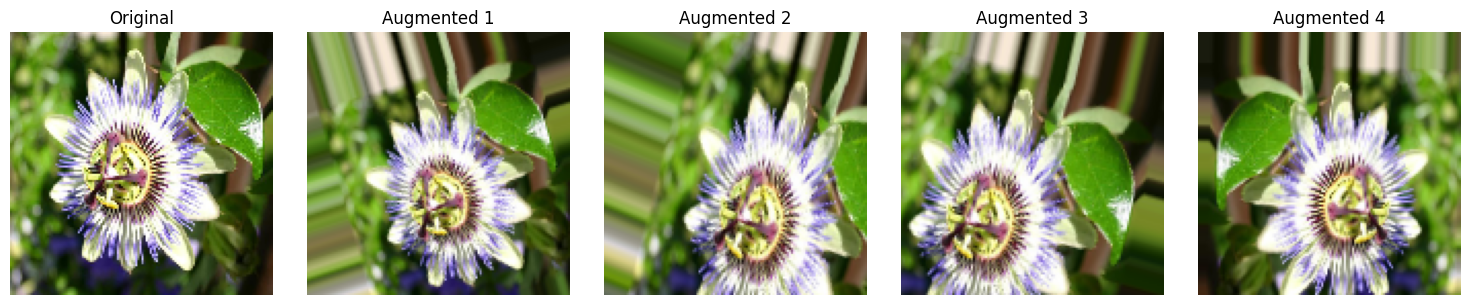

In [ ]:
visualize_augmentation(sample_image_path)


In [ ]:


# Step 3: Prepare Data for Training
# Create training and validation datasets
import tensorflow as tf

# Create file paths and labels arrays
file_paths = [os.path.join(images_path, img) for img in image_files]
labels_array = labels_zero_based  # Using 0-based labels

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    file_paths,
    labels_array,
    test_size=0.2,
    random_state=42,
    stratify=labels_array  # Maintain class distribution in split
)

# Create data generators
def create_dataset(file_paths, labels, batch_size=32):
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = img / 255.0  # Normalize
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create training and validation datasets
train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)

In [ ]:

# Step 4: Build the CNN Model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

def create_model(num_classes):
    # Use MobileNetV2 as base model
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
# Create model
num_classes = len(np.unique(labels))
model = create_model(num_classes)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks with correct file format
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',  # Changed from .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    # epochs=30,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.7641 - loss: 0.8833 - val_accuracy: 0.8352 - val_loss: 0.6169 - learning_rate: 0.0010
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.8488 - loss: 0.5508 - val_accuracy: 0.8486 - val_loss: 0.5454 - learning_rate: 0.0010
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.8728 - loss: 0.4303 - val_accuracy: 0.8553 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9067 - loss: 0.3195 - val_accuracy: 0.8626 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.9283 - loss: 0.2542 - val_accuracy: 0.8590 - val_loss: 0.4984 - learning_rate: 0.0010
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.9295 - loss: 0.2395 - val_accuracy: 0.8694 - val_loss: 0.4734 - learning_rate: 0.0010
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9418 - 

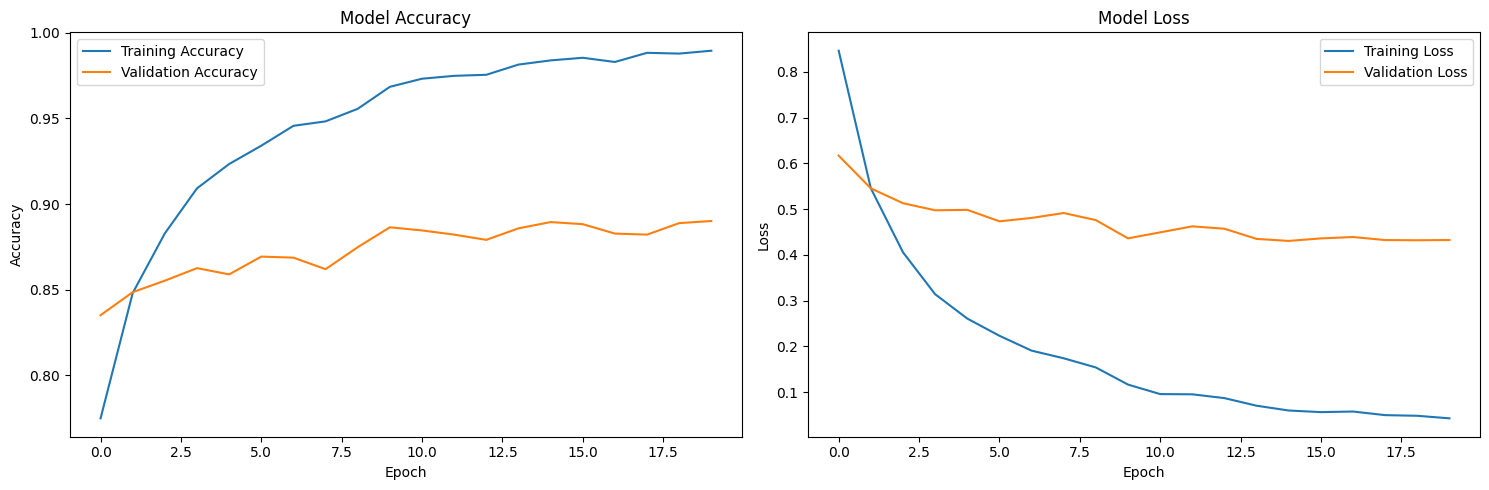

In [ ]:

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Optional: Save the final model
model.save('final_model.keras')